In [1]:
import cdsapi
import os
import xarray as xr
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from eofs.xarray import Eof
from eofs.examples import example_data_path


In [4]:
os.getcwd()

'/home/pat6/module_4/ATMS-523-Module-4-Trierweiler'

### 1. Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and total column water vapor from Jan 1979-Dec 2024 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) masked out over land - save this to your computer. The data and land sea mask is available here: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download

In [33]:
# download data
# sea_surface temperature,Total water column vapor, land_sea_mask
dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": [
        "sea_surface_temperature",
        "total_column_water_vapour",
        "land_sea_mask"
    ],
    "year": [
        "1979", "1980", "1981",
        "1982", "1983", "1984",
        "1985", "1986", "1987",
        "1988", "1989", "1990",
        "1991", "1992", "1993",
        "1994", "1995", "1996",
        "1997", "1998", "1999",
        "2000", "2001", "2002",
        "2003", "2004", "2005",
        "2006", "2007", "2008",
        "2009", "2010", "2011",
        "2012", "2013", "2014",
        "2015", "2016", "2017",
        "2018", "2019", "2020",
        "2021", "2022", "2023",
        "2024"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [65, 120, -65, -60]
}

client = cdsapi.Client()
client.retrieve(dataset, request,'module_4_HW_data.nc')

2025-10-21 22:45:44,802 INFO Request ID is 8ac92775-ab29-4ec0-9004-10d104d6fadf
2025-10-21 22:45:44,967 INFO status has been updated to accepted
2025-10-21 22:45:53,752 INFO status has been updated to running
2025-10-21 22:45:58,981 INFO status has been updated to successful


8e8d2e21aba86f1d0cd9556a3a6113c6.nc:   0%|          | 0.00/556M [00:00<?, ?B/s]

'module_4_HW_data.nc'

In [34]:
ds = xr.load_dataset('module_4_HW_data.nc')
ds

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 552, latitude: 521, longitude: 721)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-12-01
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
    expver      (valid_time) <U4 9kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    sst         (valid_time, latitude, longitude) float32 829MB nan nan ... nan
    tcwv        (valid_time, latitude, longitude) float32 829MB 1.102 ... 7.988
    lsm         (valid_time, latitude, longitude) float32 829MB 0.9839 ... 0....
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-17T23:56 GRIB to CDM+CF via cfgrib-0.9.1...

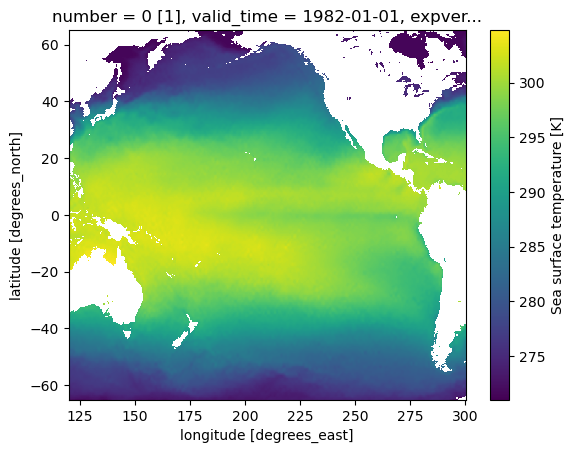

In [3]:
ds['sst'].sel(valid_time='1982-01-01').plot()

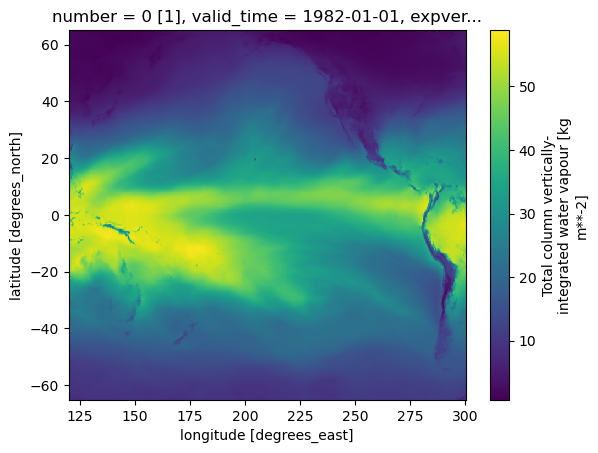

In [9]:
ds['tcwv'].sel(valid_time='1982-01-01').plot()

In [35]:
def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")


def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()                                # (time, ...)
        t_b = t.broadcast_like(da)                         # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid                            # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar  = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)


def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    """
    From linearly-detrended data, remove monthly climatology and compute monthly z-scores.
    Returns (anom, z). Works for Dataset or DataArray.
    """
    clim_src = detr if base_period is None else detr.sel({time_dim: slice(*base_period)})
    key = f"{time_dim}.month"

    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean

    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z

### 2. From the dataset shown in 1, compute anomalies by deseasonalizing the data (remove the mean monthly anomaly from the annual mean from each point) and detrend the data.

In [36]:
# detrend the data
detr = linear_detrend(ds[["sst", "tcwv"]], time_dim="valid_time")
#detr.to_netcdf('detr.nc')

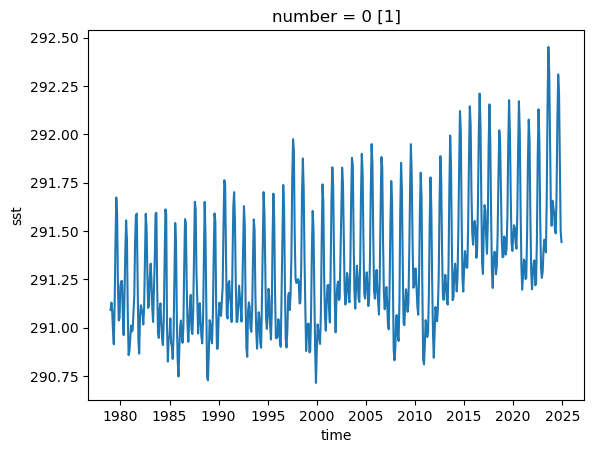

In [8]:
ds['sst'].mean(dim=('latitude','longitude')).plot()

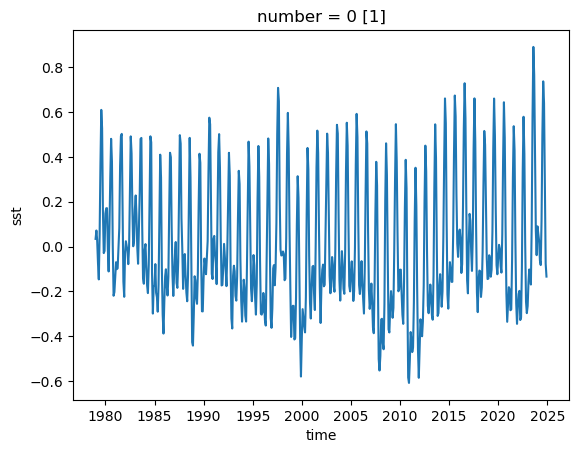

In [9]:
detr['sst'].mean(dim=('latitude','longitude')).plot()

In [37]:
# calculat anomaly
anom, z = monthly_anom_and_z(detr, time_dim="valid_time")

/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var =

In [3]:
#z = z.rename({"valid_time": "time"})
#z.to_netcdf('z.nc')
#anom.to_netcdf('anom.nc')

In [4]:
anom = xr.load_dataset('anom.nc')
sst = anom['sst']
sst = sst.rename({"valid_time": "time"})
# sst = sst.drop_vars('number')
# sst = sst.drop_vars('month')
# sst = sst.drop_vars('expver')

In [5]:
# creating the weights and creating the solver
coslat = np.cos(np.deg2rad(sst.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst, weights=wgts)

In [24]:
eof1 = solver.eofsAsCorrelation(neofs=5)
pc1 = solver.pcs(npcs=5, pcscaling=1)

In [3]:
#eof1.to_netcdf('/home/pat6/module_4/ATMS-523-Module-4-Trierweiler/eof1.nc')
eof1 = xr.load_dataarray('/home/pat6/module_4/ATMS-523-Module-4-Trierweiler/eof1.nc')

### 3. Perform an EOF analysis on the SST anomalies and plot a map of the first 5 EOFs, following M04N05.

/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/pat6/envs/xarray-climate/lib/python3.13/site-p

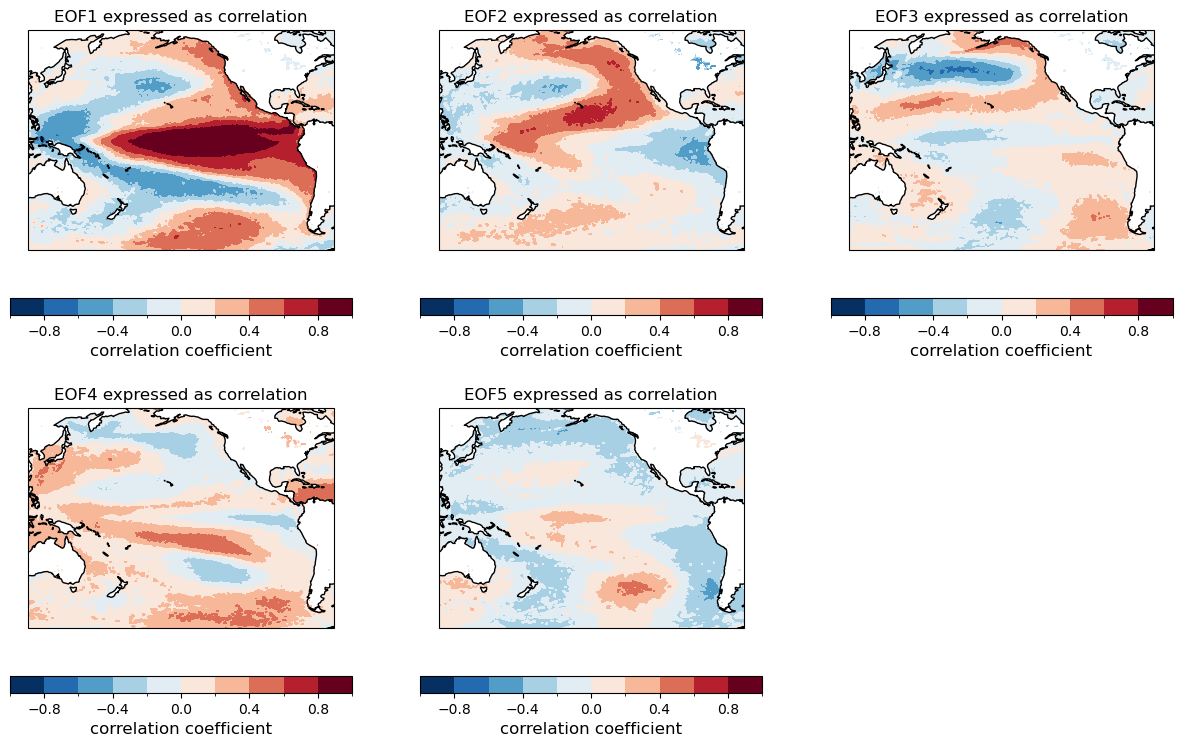

In [13]:
prj = ccrs.PlateCarree(central_longitude = 190)
fig, axes = plt.subplots(
    2, 3, figsize=(15, 9), 
    subplot_kw={'projection': prj, 
    "aspect": 1},
)
ax1 = axes[0][0]
ax2 = axes[0][1]
ax3 = axes[0][2]
ax4 = axes[1][0]
ax5 = axes[1][1]
clevs = np.linspace(-1, 1, 11)

ax_list = [ax1,ax2,ax3,ax4,ax5]
i = 0
for x in ax_list:
    plot_eof_sst = eof1[i].plot.contourf(ax=x, levels=clevs, 
    transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r, add_colorbar=False)
    fill = eof1[i].plot.contourf(ax=x, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
    x.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
    cb = plt.colorbar(fill, orientation='horizontal')
    cb.set_label('correlation coefficient', fontsize=12)
    x.set_title('EOF{} expressed as correlation'.format(i+1), fontsize=12)
    i += 1

fig.delaxes(axes[1][2])

Text(0.5, 1.0, 'PC1 Time Series')

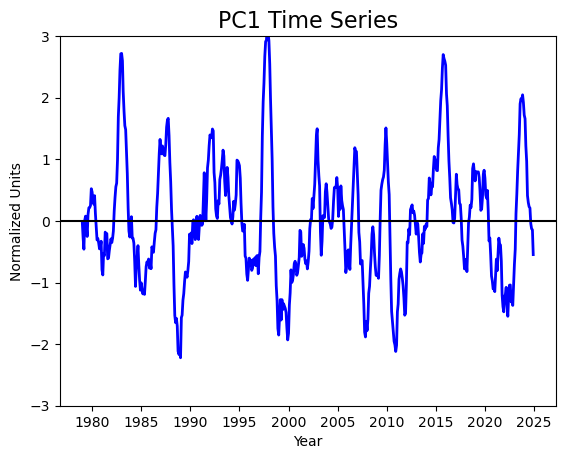

In [25]:
# Plot the leading PC time series.
plt.figure()
pc1[:, 0].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC1 Time Series', fontsize=16)

### 4. Plot the percent of variance explained by the first 10 EOFs.

In [ ]:
varfrac = solver.varianceFraction()

(4.464185504550119e-16, 0.24132317304611206)

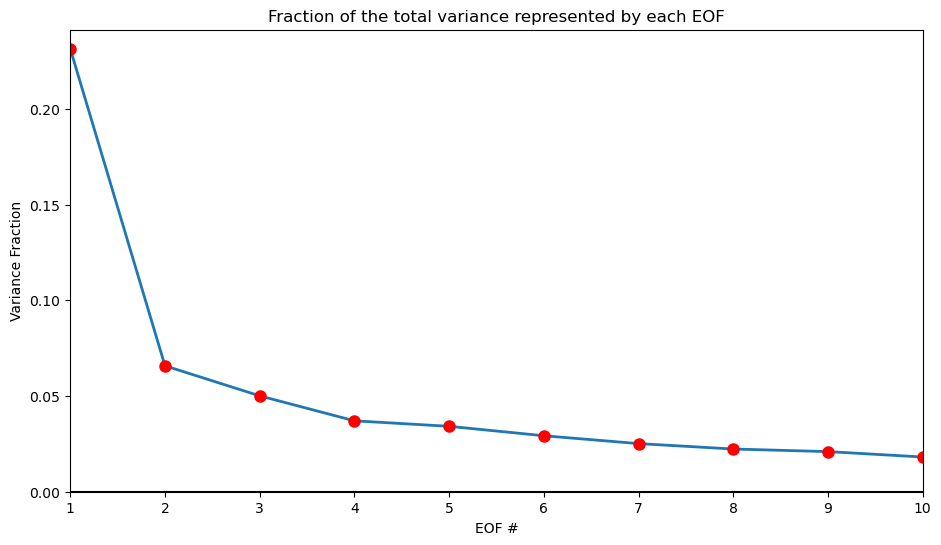

In [ ]:
# Plot the percent of variance explained by the first 10 EOFs.
plt.figure(figsize=(11,6))
eof_num = range(1, 11)
plt.plot(eof_num, varfrac[0:10], linewidth=2)
plt.plot(eof_num, varfrac[0:10], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 11))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 10)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)

### 5. Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient (xarray.corr) of the reconstructed monthly time series and the "observed" SST time series.

In [15]:
# reconstruct
reconstruction = solver.reconstructedField(5)
reconstruction

<xarray.DataArray 'sst' (time: 552, latitude: 521, longitude: 721)> Size: 829MB
array([[[        nan,         nan,         nan, ...,  0.26682994,
          0.27596572,  0.28518283],
        [        nan,         nan,         nan, ...,  0.271885  ,
          0.2747866 ,  0.27569774],
        [        nan,         nan,         nan, ...,  0.3026714 ,
          0.2974902 ,  0.29229432],
        ...,
        [-0.01964998, -0.02495277, -0.03029654, ...,         nan,
                 nan,         nan],
        [-0.02006874, -0.02406432, -0.02803234, ...,         nan,
                 nan,         nan],
        [-0.0233586 , -0.02726935, -0.03119792, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,  0.35587996,
          0.36861825,  0.38157293],
        [        nan,         nan,         nan, ...,  0.36286575,
          0.36447456,  0.36562487],
        [        nan,         nan,         nan, ...,  0.3818962 ,
          0.3814935 ,  0.3810574 ],
...
        [-0.02014011, -0.02331016, -0.02640076, ...,         nan,
                 nan,         nan],
        [-0.02316328, -0.02502652, -0.02689593, ...,         nan,
                 nan,         nan],
        [-0.02554063, -0.02665262, -0.02711658, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,  0.13792564,
          0.14300558,  0.14803581],
        [        nan,         nan,         nan, ...,  0.14651448,
          0.15065205,  0.15450644],
        [        nan,         nan,         nan, ...,  0.17162845,
          0.17452388,  0.17736873],
        ...,
        [-0.01693936, -0.01718851, -0.01742575, ...,         nan,
                 nan,         nan],
        [-0.0208763 , -0.02123897, -0.02160095, ...,         nan,
                 nan,         nan],
        [-0.02232257, -0.02318068, -0.02467321, ...,         nan,
                 nan,         nan]]], shape=(552, 521, 721), dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-12-01
  * latitude   (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
    number     (time) int64 4kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    expver     (time) <U4 9kB '0001' '0001' '0001' ... '0001' '0001' '0001'
    month      (time) int64 4kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:  sst_reconstructed_with_5_EOFs

In [16]:
#reconstruction.to_netcdf('reconstruction.nc')

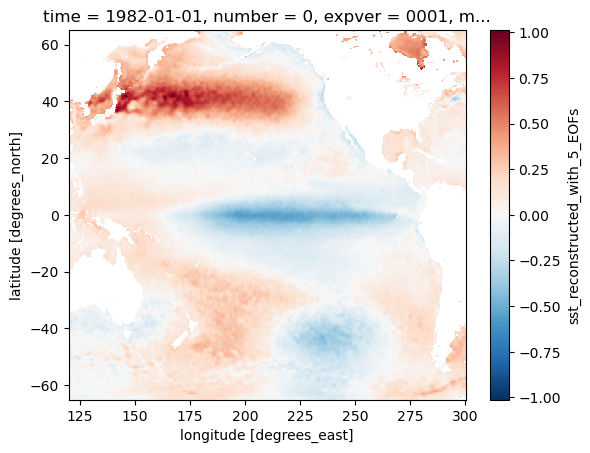

In [17]:
reconstruction.sel(time='1982-01-01').plot()

In [18]:
# Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's 
# correlation coefficient (xarray.corr) of the reconstructed monthly 
# time series and the "observed" SST time series.
reconstruction = xr.load_dataarray('reconstruction.nc')
# sst_corr = xr.corr(sst, reconstruction,dim="time")
# sst_corr.plot()

In [19]:
z = xr.open_dataset('z.nc')
eof1 = xr.load_dataarray('/home/pat6/module_4/ATMS-523-Module-4-Trierweiler/eof1.nc')

### 6. Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean column water vapor anomalies

In [21]:
# reconstruction using EOF1
reconst_1 = solver.reconstructedField(1)


/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


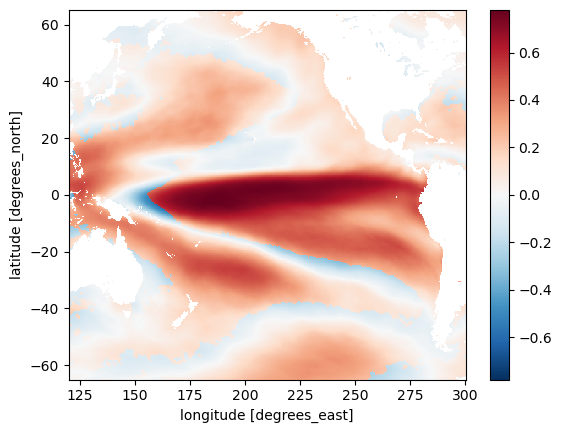

In [ ]:
xr.corr(z['tcwv'],reconst_1,dim='time').plot()